# House Prices: Advanced Regression Techniques

Predict sales prices and practice feature engineering, RFs, and gradient boosting

In [146]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics

path = "./"
filename_test = os.path.join(path,'test.csv')
# filename_submit = os.path.join(path,'SampleResults3.csv')
filename_train = os.path.join(path,"preprocess_train.csv")
df_train = pd.read_csv(filename_train,na_values=['NA'])
df_train = df_train.drop(['Id'], axis = 1)

# Data preprocessing

In [140]:
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)

def encode(df, zscoreY=False):
# encode dummy and zscores
    if not zscoreY:
        col = filter(lambda name: name != "SalePrice", df_train.columns)
    else:
        col = df_train.columns[:]
        
    for i in range(len(col)):
        colName = col[i]
        if df.dtypes[colName] == 'O':
            encode_text_dummy(df, colName)
        else:
            missing_median(df, colName)
            encode_numeric_zscore(df, colName)

# Cross Validation

In [158]:
def plotUncertainty(model, X, Y):
    n = len(Y)
    pred_Y, sigma = model.predict(X, return_std=True)
    x_range = range(n)
    subRange = x_range[::5]
    subPred_Y = getSubMatrix(pred_Y, subRange)
    sub_sigma = np.array(map(lambda x: sigma[x], subRange))
    
    fig = plt.figure(figsize=(12, 9))
    plt.plot(subRange, getSubMatrix(Y, subRange), 'r.', markersize=10, label=u'Observations')
    plt.plot(subRange, subPred_Y, 'b.', markersize=10, label=u'Prediction')
    plt.fill(np.concatenate([subRange, subRange[::-1]]), np.concatenate([subPred_Y - 128200 * sub_sigma,
                        (subPred_Y + 128200 * sub_sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='80% confidence interval')
    plt.xlabel('$index$')
    plt.ylabel('$price$')
    plt.legend(loc='upper left')
#     plt.show()
    
def getSubMatrix(M, index):
    res = []
    for ind in index:
        res.append(M[ind])
    return np.concatenate(res)

def crossVal(model, X, Y, ifPlotUncertainty=False):
    kf = KFold(10)

    oos_y = []
    oos_pred = []
    fold = 1
    count = 0
    for train, test in kf.split(X):
        print("Fold #{}".format(fold))

        x_train = X[train]
        y_train = Y[train]
        x_test = X[test]
        y_test = Y[test]
        model = model.fit(x_train,y_train)
        
        pred = model.predict(x_test)
        if ifPlotUncertainty:
            plotUncertainty(model, x_test, y_test)
            plt.show()
            
        i = 0
        while i < len(pred):
            if abs(pred[i] - y_test[i]) > 10000000:
                pred = np.delete(pred, i, 0)
                y_test = np.delete(y_test, i, 0)
                i -= 1
                count += 1
            i += 1
        oos_y.append(y_test)
        oos_pred.append(pred)
        
        # Measure this fold's RMSE
        score = np.sqrt(metrics.mean_squared_error(pred,y_test))
        print("Fold score (RMSE): {}".format(score))
        fold += 1

    # Build the oos prediction list and calculate the error.
    oos_y = np.concatenate(oos_y)
    oos_pred = np.concatenate(oos_pred)
    score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
    print("Final, out of sample score (RMSE): {}".format(score))

In [147]:
df_train = pd.read_csv(filename_train,na_values=['NA'])
df_train = df_train.drop(['Id'], axis = 1)
encode(df_train)

header = list(df_train.columns.values)
X = np.hstack((np.mat(df_train[header[:header.index('SalePrice')]]), np.mat(df_train[header[header.index('SalePrice') + 1:]])))
Y = np.mat(df_train['SalePrice']).T

In [25]:
import numpy
numpy.set_printoptions(threshold=numpy.nan)

# Linear Regression

In [47]:
model = LinearRegression()
model = model.fit(X, Y)
crossVal(model, X, Y)

Fold #1
Fold score (RMSE): 21907.3895628
Fold #2
Fold score (RMSE): 28288.6608497
Fold #3
Fold score (RMSE): 26634.0558072
Fold #4
Fold score (RMSE): 38131.4293176
Fold #5
Fold score (RMSE): 35007.1054816
Fold #6
Fold score (RMSE): 38973.0808092
Fold #7
Fold score (RMSE): 27429.6144037
Fold #8
Fold score (RMSE): 27699.1143764
Fold #9
Fold score (RMSE): 59818.2603357
Fold #10
Fold score (RMSE): 25226.5282789
Final, out of sample score (RMSE): 34539.1615156


# Decision Tree and Random Forest

In [48]:
import numpy as np
from sklearn import tree
from sklearn import ensemble
import matplotlib.pyplot as plt


clt = tree.DecisionTreeRegressor()
clt = clt.fit(X, Y)
crossVal(clt, X, Y)

Fold #1
Fold score (RMSE): 36260.6271035
Fold #2
Fold score (RMSE): 38034.7485097
Fold #3
Fold score (RMSE): 33588.9291952
Fold #4
Fold score (RMSE): 42727.575083
Fold #5
Fold score (RMSE): 40842.9617004
Fold #6
Fold score (RMSE): 29744.7509402
Fold #7
Fold score (RMSE): 28731.230414
Fold #8
Fold score (RMSE): 35408.5509158
Fold #9
Fold score (RMSE): 56118.3021903
Fold #10
Fold score (RMSE): 34473.2896368
Final, out of sample score (RMSE): 38321.2152159


In [49]:
rdf = ensemble.RandomForestRegressor()
rdf.fit(X, Y)
crossVal(rdf, X, Y)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Fold #1


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Fold score (RMSE): 27313.0637764
Fold #2
Fold score (RMSE): 28397.0536573
Fold #3
Fold score (RMSE): 23917.0213456
Fold #4
Fold score (RMSE): 43271.6010462
Fold #5
Fold score (RMSE): 35128.1239867
Fold #6
Fold score (RMSE): 27040.4946764
Fold #7
Fold score (RMSE): 26052.6945105
Fold #8
Fold score (RMSE): 26055.9576353
Fold #9
Fold score (RMSE): 45482.1742977
Fold #10
Fold score (RMSE): 28928.8207699
Final, out of sample score (RMSE): 31976.8441112


Fold #1


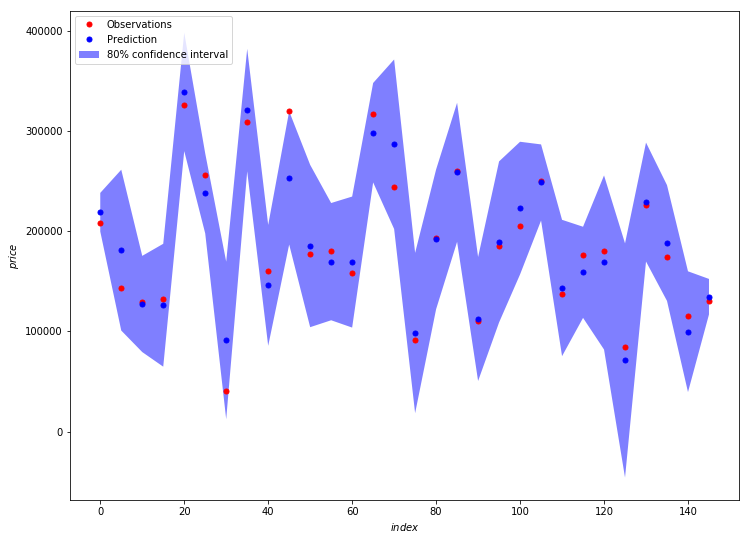

Fold score (RMSE): 29152.0665092
Fold #2


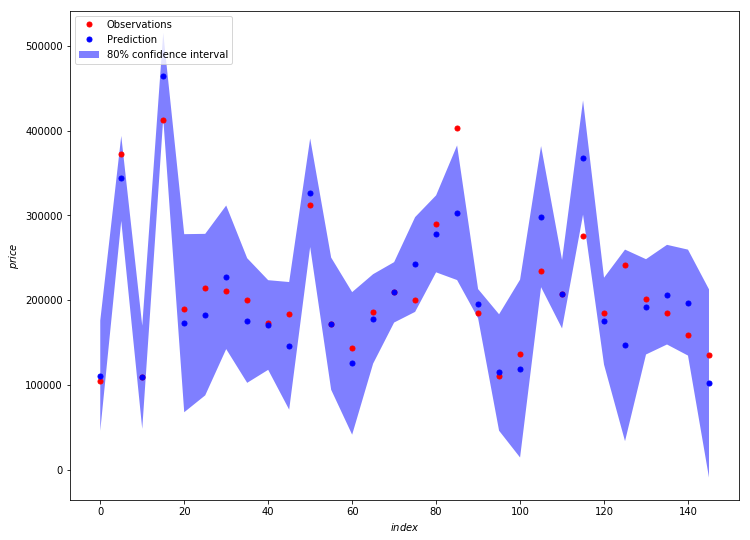

Fold score (RMSE): 51741.6380545
Fold #3


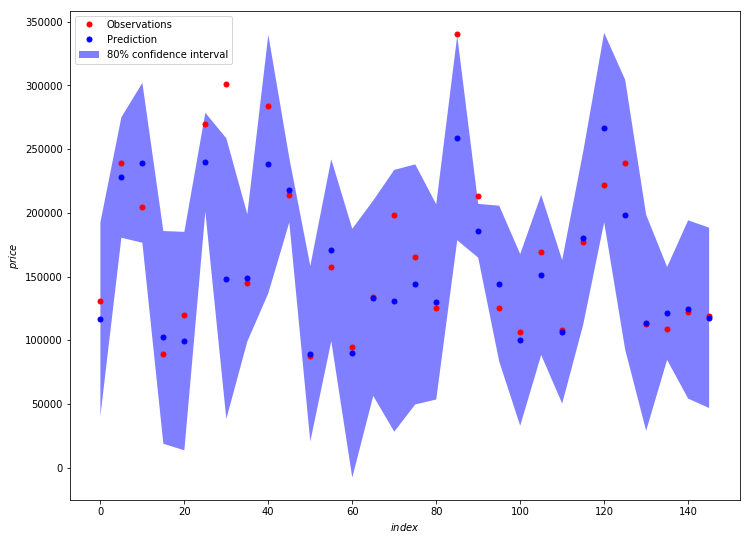

Fold score (RMSE): 44307.0960536
Fold #4


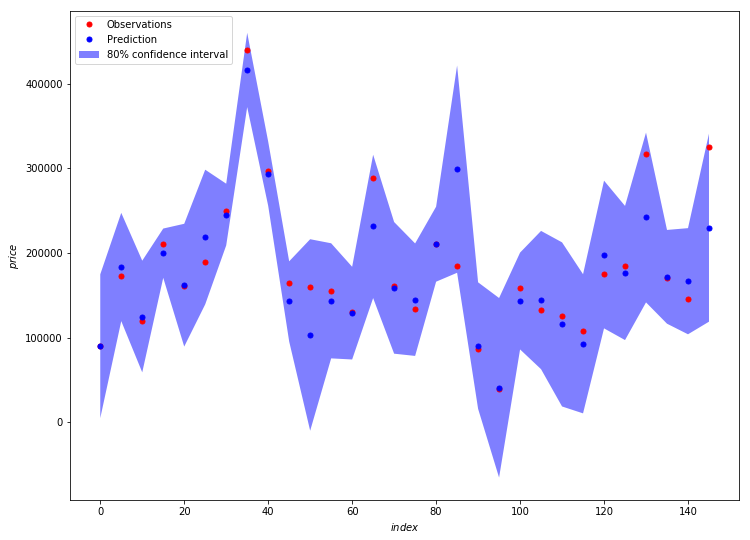

Fold score (RMSE): 33651.124938
Fold #5


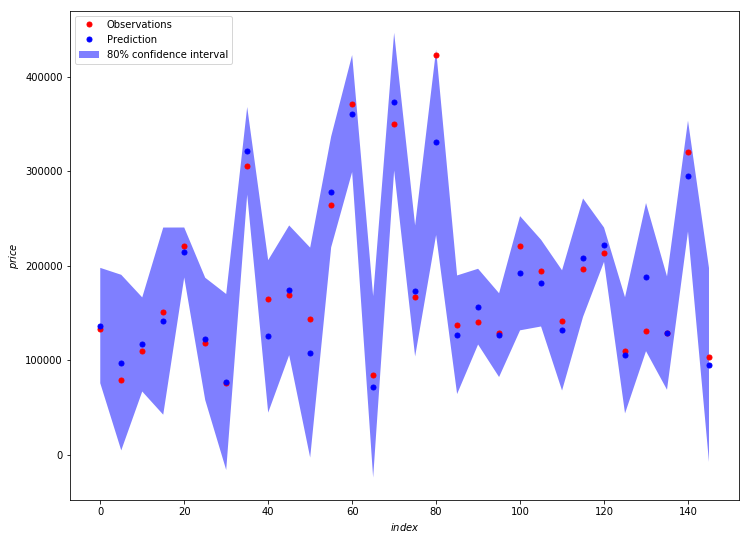

Fold score (RMSE): 49400.0602059
Fold #6


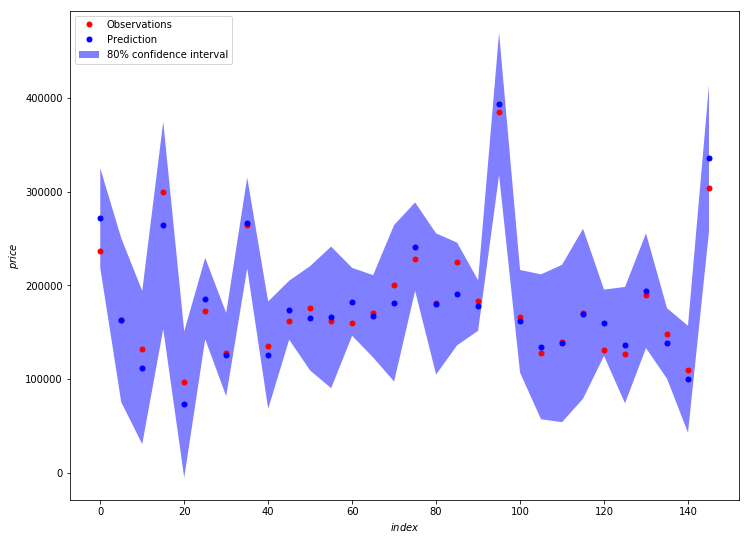

Fold score (RMSE): 38536.9072358
Fold #7


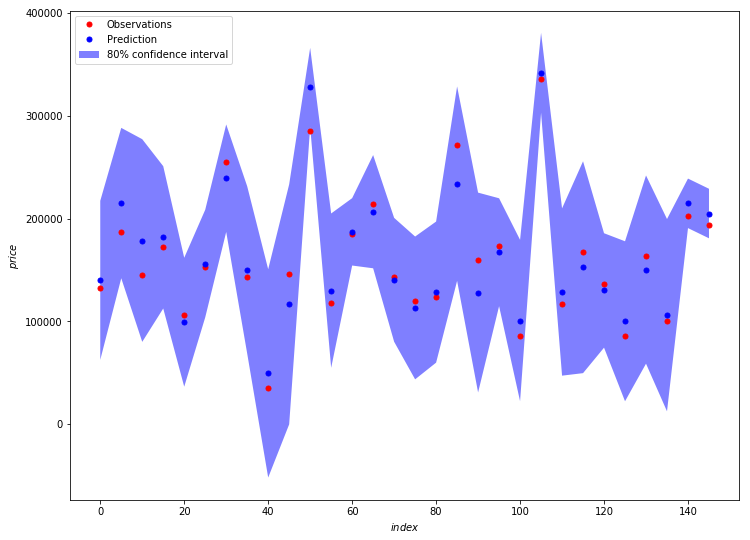

Fold score (RMSE): 30473.8041762
Fold #8


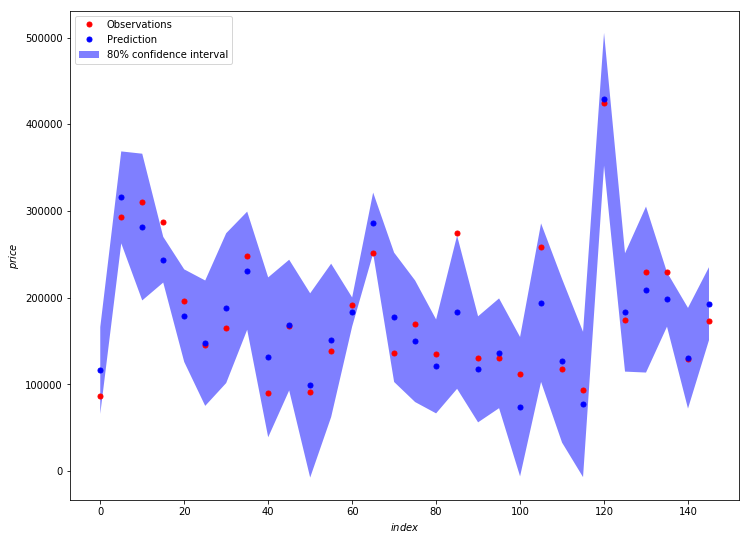

Fold score (RMSE): 23641.5941642
Fold #9


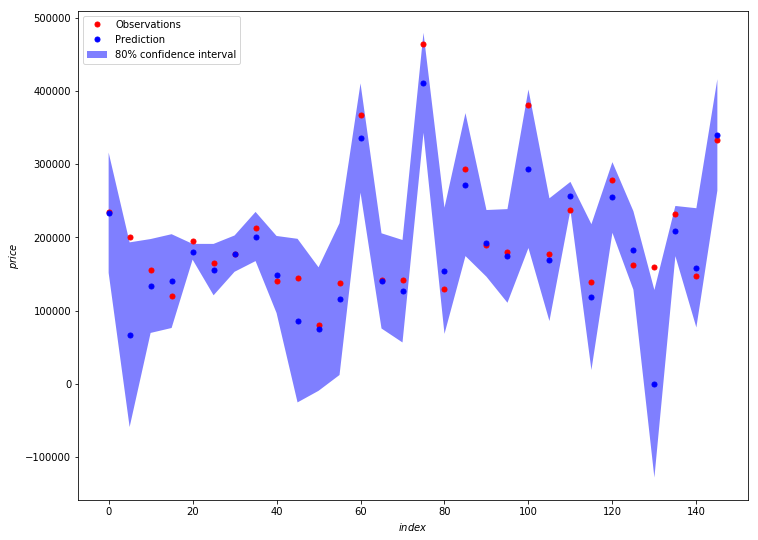

Fold score (RMSE): 48777.341614
Fold #10


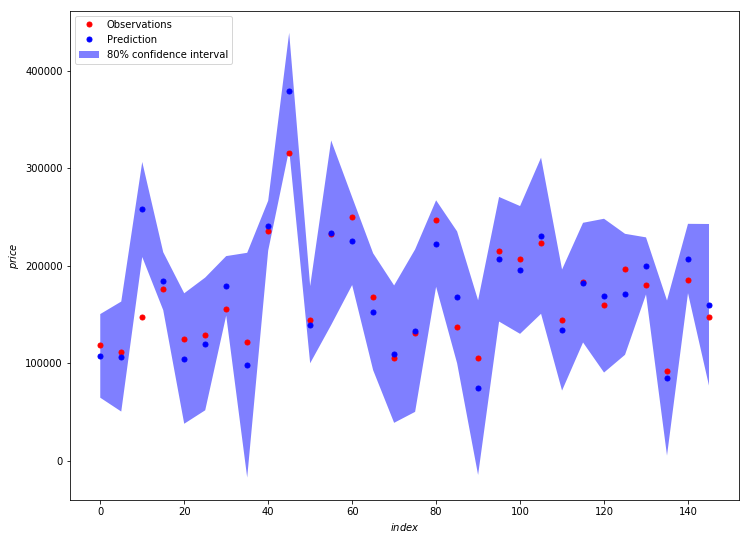

Fold score (RMSE): 25717.0294614
Final, out of sample score (RMSE): 38828.0679446


In [159]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

rbfKernel = 1.0 * RBF(length_scale=1.0)

gp = GaussianProcessRegressor(kernel=rbfKernel)
gp = gp.fit(X, Y)
crossVal(gp, X, Y, ifPlotUncertainty=True)

Fold #1


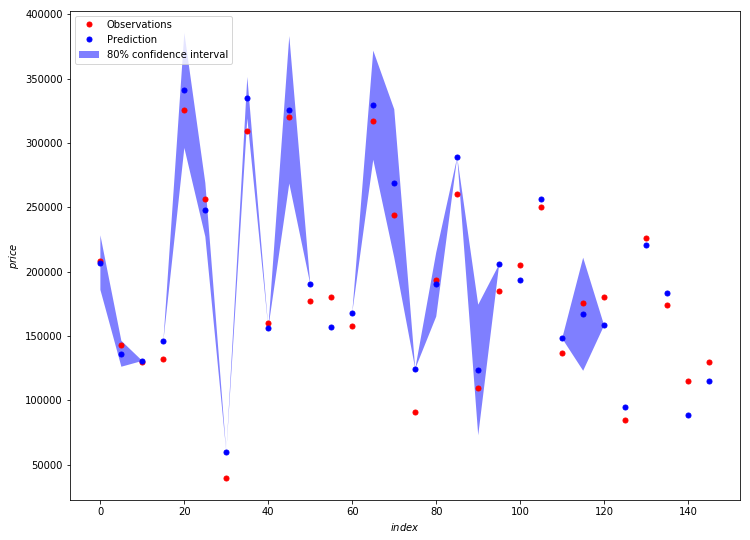

Fold score (RMSE): 21868.6567412
Fold #2


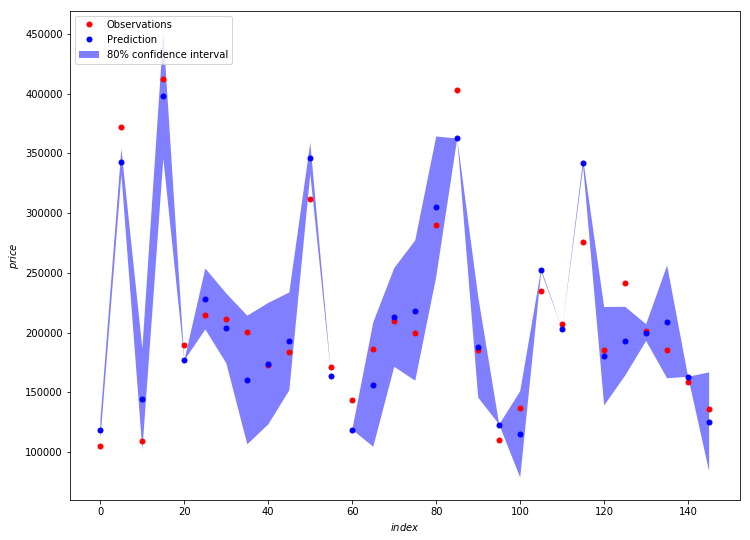

Fold score (RMSE): 28151.3652573
Fold #3


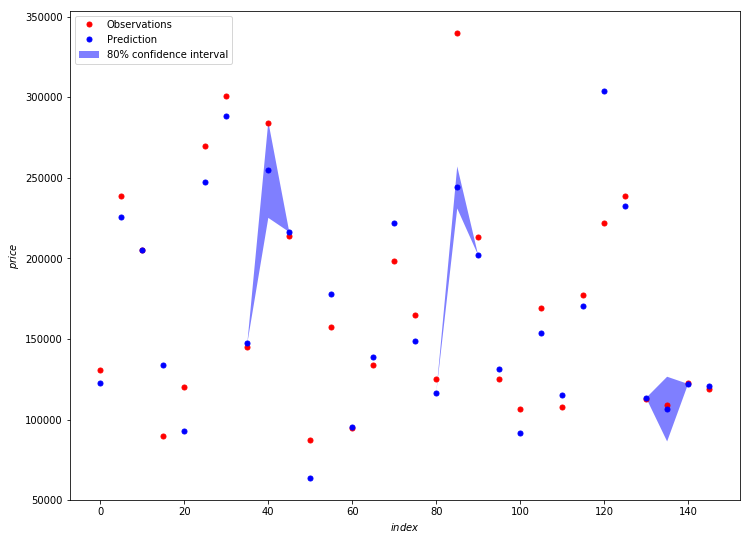

Fold score (RMSE): 26559.8015515
Fold #4


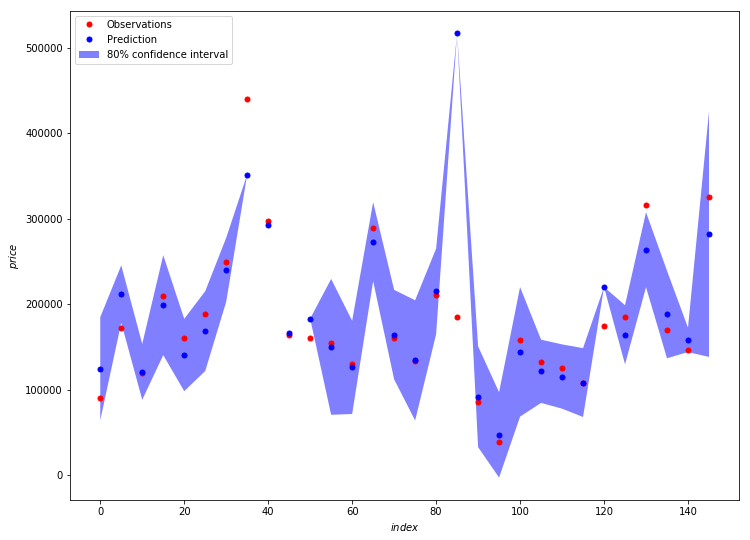

Fold score (RMSE): 38268.8028755
Fold #5


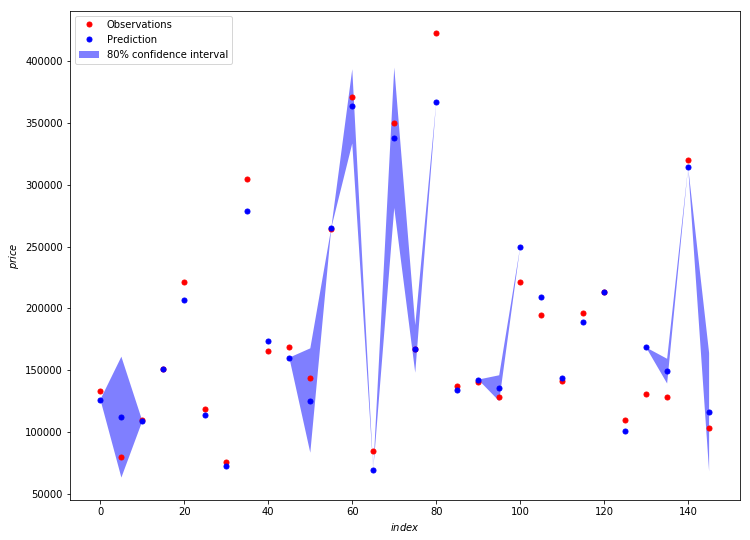

Fold score (RMSE): 34188.43716
Fold #6


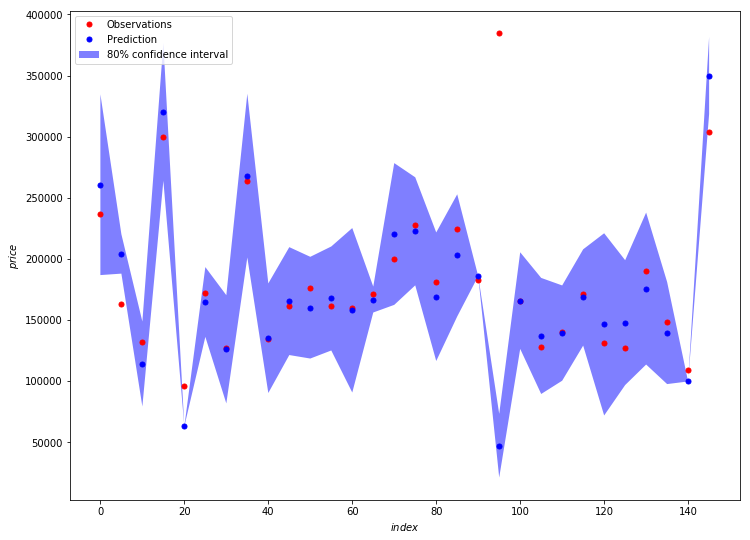

Fold score (RMSE): 38968.1196473
Fold #7


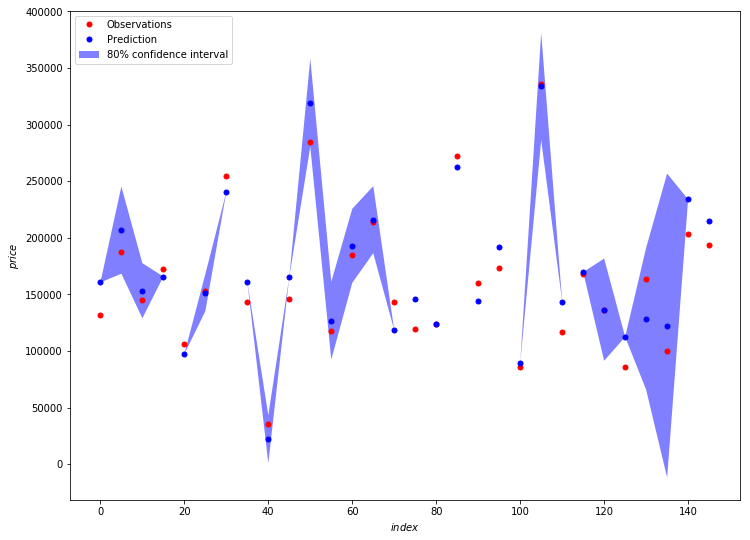

Fold score (RMSE): 27577.0904557
Fold #8


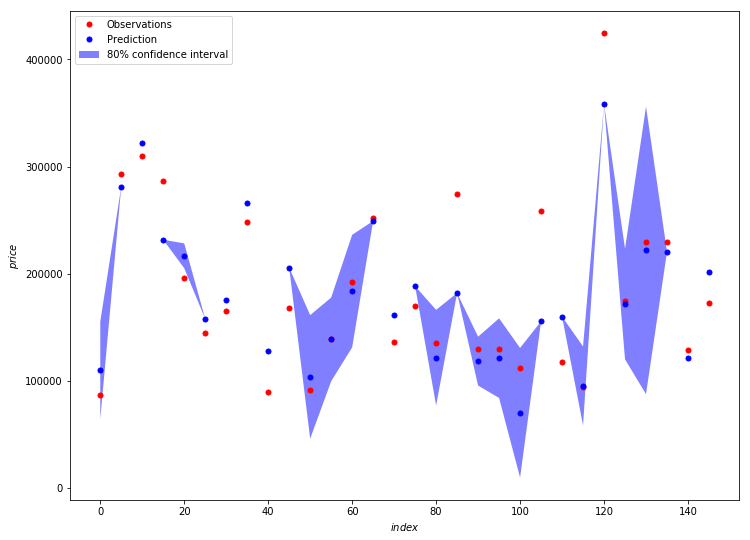

Fold score (RMSE): 27232.1027754
Fold #9


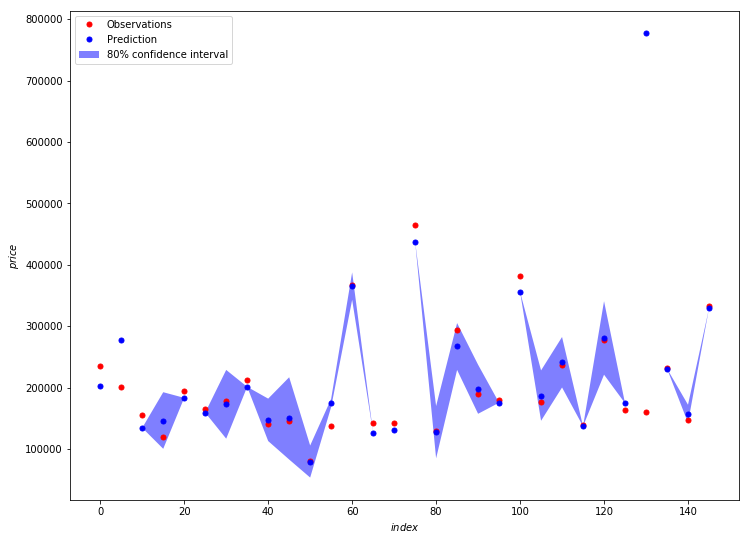

Fold score (RMSE): 59179.8566883
Fold #10


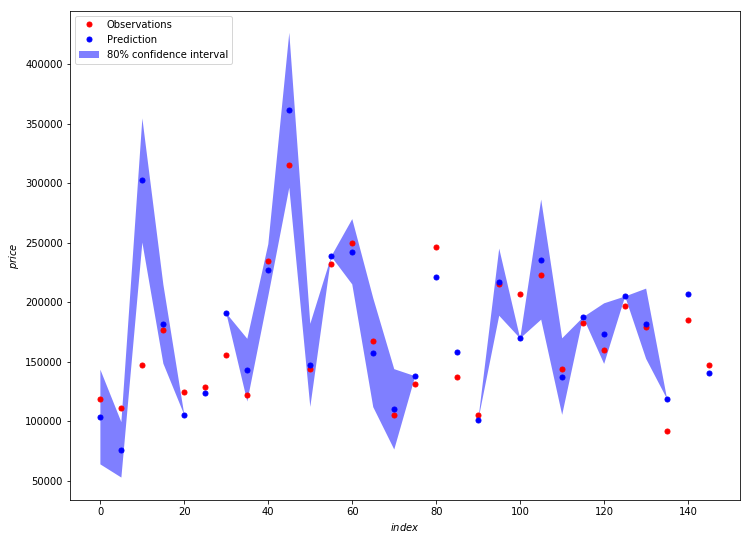

Fold score (RMSE): 25052.8592233
Final, out of sample score (RMSE): 34292.8709243


In [161]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct

polyKernel = DotProduct(sigma_0=1.0)

gp = GaussianProcessRegressor(kernel=polyKernel)
gp = gp.fit(X, Y)
crossVal(gp, X, Y, ifPlotUncertainty=True)

In [172]:
import numpy as np
from sklearn.svm import SVR
svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svm.fit(X, Y)
crossVal(svm, X, Y)

Fold #1
Fold score (RMSE): 68996.0253007
Fold #2
Fold score (RMSE): 84079.6358253
Fold #3
Fold score (RMSE): 81683.4904858
Fold #4
Fold score (RMSE): 85176.2238453
Fold #5
Fold score (RMSE): 98706.7938844
Fold #6
Fold score (RMSE): 79311.9907458
Fold #7
Fold score (RMSE): 72428.8672957
Fold #8
Fold score (RMSE): 71161.7544062
Fold #9
Fold score (RMSE): 93809.0247799
Fold #10
Fold score (RMSE): 73287.2240129
Final, out of sample score (RMSE): 81407.3263723


In [180]:
svm.support_vectors_.shape

(1314, 225)

In [127]:
import math
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

df_train = pd.read_csv(filename_train,na_values=['NA'])
df_train = df_train.drop(['Id'], axis = 1)
encode(df_train, zscoreY=True)

header = list(df_train.columns.values)
X = np.hstack((np.mat(df_train[header[:header.index('SalePrice')]]), np.mat(df_train[header[header.index('SalePrice') + 1:]])))
Y = np.mat(df_train['SalePrice']).T

rbfKernel = RBF()

gp = GaussianProcessRegressor(kernel=rbfKernel)
gp = gp.fit(X, Y)
crossVal(gp, X, Y)

Fold #1
Fold score (RMSE): 0.28459062608
Fold #2
Fold score (RMSE): 0.41876616373
Fold #3
Fold score (RMSE): 0.347226132632
Fold #4
Fold score (RMSE): 0.520211590556
Fold #5
Fold score (RMSE): 0.403923982055
Fold #6
Fold score (RMSE): 0.350032293437
Fold #7
Fold score (RMSE): 0.274212828378
Fold #8
Fold score (RMSE): 0.289389231596
Fold #9
Fold score (RMSE): 0.399584537855
Fold #10
Fold score (RMSE): 0.295235277696
Final, out of sample score (RMSE): 0.365922215081


In [132]:
pred_Y, sigma = gp.predict(X, return_std=True)
# plotUncertainty(gp, X, Y)
sigma

array([  1.00305847e-05,   1.00114015e-05,   1.01485168e-05, ...,
         1.00129871e-05,   9.99058684e-06,   9.99770199e-06])

In [136]:
df_test = pd.read_csv(filename_test,na_values=['NA'])
df_train = pd.read_csv(filename_train,na_values=['NA'])
Y_train = np.mat(df_train['SalePrice'])
df_train = df_train.drop('SalePrice', axis = 1)
df = pd.DataFrame()
for col in df_train.columns:
    df[col] = df_test[col]
df_test = df
encode(df_train)
encode(df_test)

for i in range(len(df_train.columns)):
    col = df_train.columns[i]
    if col not in df_test.columns:
        df_test.insert(loc=i, column=col, value=0)
X_test = np.mat(df_test)
X_train = np.mat(df_train)

In [137]:
print len(X_train)

1460


In [138]:
rdf = ensemble.RandomForestRegressor()
rdf.fit(X_train, Y_train.T)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [141]:
res = rdf.predict(X_test)
np.savetxt("foo.csv", res, delimiter=",")

In [118]:
df_train.columns

Index([u'Id', u'MSSubClass', u'LotFrontage', u'LotArea', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'BsmtFinSF1',
       u'BsmtFinSF2',
       ...
       u'PavedDrive-Y', u'SaleType-COD', u'SaleType-CWD', u'SaleType-Con',
       u'SaleType-ConLD', u'SaleType-ConLI', u'SaleType-ConLw',
       u'SaleType-New', u'SaleType-Oth', u'SaleType-WD'],
      dtype='object', length=221)

In [119]:
df_test.columns

Index([u'Id', u'MSSubClass', u'LotFrontage', u'LotArea', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'BsmtFinSF1',
       u'BsmtFinSF2',
       ...
       u'PavedDrive-Y', u'SaleType-COD', u'SaleType-CWD', u'SaleType-Con',
       u'SaleType-ConLD', u'SaleType-ConLI', u'SaleType-ConLw',
       u'SaleType-New', u'SaleType-Oth', u'SaleType-WD'],
      dtype='object', length=221)